In [2]:
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2

In [3]:
from simple_vector_db.quantization.vector_quantizer import VectorQuantizer
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_digits
import pandas as pd
import psutil
import sys
import seaborn as sns

In [69]:
vectors_to_quantize = load_digits().data

In [74]:
m_chunks_list = range(2, 32, 2)
res = []
for m_chunk in m_chunks_list:
    k_centroids_list = np.array(range(2, 32, 2)) * m_chunk
    for k_centroids in k_centroids_list:
        try:
            quantizer = VectorQuantizer(m_chunks=m_chunk, k_centroids=k_centroids)
            quantized_vectors = quantizer.quantize_vectors(vectors_to_quantize)
            print(m_chunk, k_centroids, (vectors_to_quantize.size * vectors_to_quantize.itemsize) / 1024,
                  (quantized_vectors.size * quantized_vectors.itemsize) / 1024)
            rebuilt_vector = quantizer.rebuild_vector(quantized_vectors[0])
            compression_mse = mean_squared_error(vectors_to_quantize[0], rebuilt_vector)
            res.append(
                {"Nombre de sections": m_chunk, "Nombre de centroïdes par section": k_centroids,
                 "mesure MSE": compression_mse,
                 "mémoire en kB": (quantized_vectors.size * quantized_vectors.itemsize) / 1024})
        except ValueError:
            print(m_chunk, k_centroids, "ERROR")

res = pd.DataFrame(res)

<class 'numpy.uint8'>
2 4 898.5 3.509765625
<class 'numpy.uint8'>
2 8 898.5 3.509765625
<class 'numpy.uint8'>
2 12 898.5 3.509765625
<class 'numpy.uint8'>
2 16 898.5 3.509765625
<class 'numpy.uint8'>
2 20 898.5 3.509765625
<class 'numpy.uint8'>
2 24 898.5 3.509765625
<class 'numpy.uint8'>
2 28 898.5 3.509765625
<class 'numpy.uint8'>
2 32 898.5 3.509765625
<class 'numpy.uint8'>
2 36 898.5 3.509765625
<class 'numpy.uint8'>
2 40 898.5 3.509765625
<class 'numpy.uint8'>
2 44 898.5 3.509765625
<class 'numpy.uint8'>
2 48 898.5 3.509765625
<class 'numpy.uint8'>
2 52 898.5 3.509765625
<class 'numpy.uint8'>
2 56 898.5 3.509765625
<class 'numpy.uint8'>
2 60 898.5 3.509765625
<class 'numpy.uint8'>
4 8 898.5 7.01953125
<class 'numpy.uint8'>
4 16 898.5 7.01953125
<class 'numpy.uint8'>
4 24 898.5 7.01953125
<class 'numpy.uint8'>
4 32 898.5 7.01953125
<class 'numpy.uint8'>
4 40 898.5 7.01953125
<class 'numpy.uint8'>
4 48 898.5 7.01953125
<class 'numpy.uint8'>
4 56 898.5 7.01953125
<class 'numpy.uint8'

In [97]:
res

,Nombre de sections,Nombre de centroïdes par section,mesure MSE,mémoire en kB
0,2,4,11.666371,3.509766
1,2,8,9.016660,3.509766
2,2,12,4.053078,3.509766
3,2,16,3.006581,3.509766
4,2,20,3.038386,3.509766
5,2,24,3.143916,3.509766
6,2,28,3.127255,3.509766
7,2,32,2.815170,3.509766
8,2,36,2.807794,3.509766
9,2,40,2.846483,3.509766


In [5]:
#sns.kdeplot(data = res,x = "m_chunk", y = 'k_centroids',hue = "mse", fill = True)
sns.set_style("whitegrid")
colors = ["#4AB8CB", "#0C1944", "#737E9A", "#1293B0", "#505C7E" ]
# Set your custom color palette
custom_palette = sns.color_palette(colors)

/var/folders/6f/tzp_vm_s0g53_39ds1grlmsm0000gn/T/ipykernel_12928/3382152310.py:6: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns_plot = sns.scatterplot(data=res, x="Nombre de centroïdes par section", y="mesure MSE", hue="Nombre de sections",


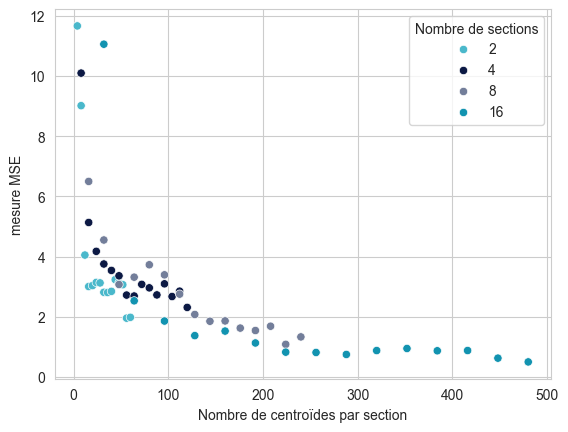

In [100]:
sns_plot = sns.scatterplot(data=res, x="Nombre de centroïdes par section", y="mesure MSE", hue="Nombre de sections",
                           palette=custom_palette)
fig = sns_plot.get_figure()
fig.savefig("../figures/mse_vs_params.png")

/var/folders/6f/tzp_vm_s0g53_39ds1grlmsm0000gn/T/ipykernel_12928/1448839332.py:1: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns_plot = sns.scatterplot(data=res, x="Nombre de centroïdes par section", y="mémoire en kB", hue="Nombre de sections",


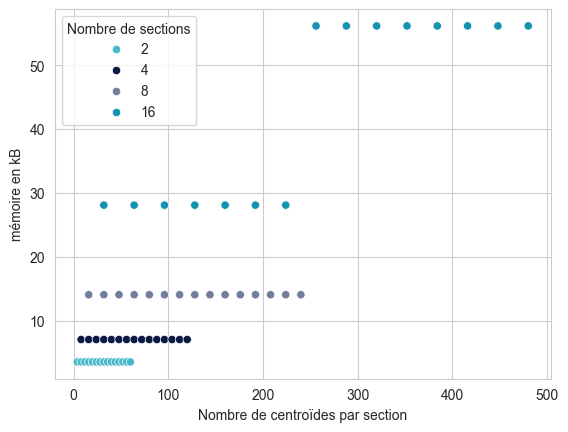

In [101]:
sns_plot = sns.scatterplot(data=res, x="Nombre de centroïdes par section", y="mémoire en kB", hue="Nombre de sections",
                           palette=custom_palette)
fig = sns_plot.get_figure()
fig.savefig("../figures/memory_vs_params.png")

## PQ parameters vs Recall 

/var/folders/hk/0l14bwkn49jbqydzz2s6q7_c0000gn/T/ipykernel_82668/4229637725.py:2: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns_plot = sns.scatterplot(data=bench_kmeans, x="Nombre de centroïdes par section", y="rappel @ 10",


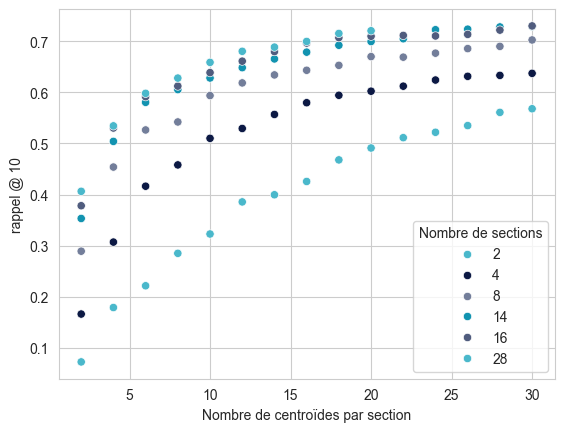

In [33]:
bench_kmeans = pd.read_csv("../figures/bench_results_pq_bck.csv")
sns_plot = sns.scatterplot(data=bench_kmeans, x="Nombre de centroïdes par section", y="rappel @ 10",
                           hue="Nombre de sections",
                           palette=custom_palette)
fig = sns_plot.get_figure()
fig.savefig("../figures/pq_recall_vs_params.png")

## PQ RECALL VS SPEED

In [16]:
bench_kmeans.groupby("recall").agg({"nb_requests_per_second":"mean"})

,nb_requests_per_second
recall,
0.072727,87.0
0.179091,89.0
0.221636,99.0
0.285091,97.0
0.322909,84.0
0.385636,90.0
0.399636,85.0
0.425636,87.0


/var/folders/hk/0l14bwkn49jbqydzz2s6q7_c0000gn/T/ipykernel_82668/738595882.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_plot = sns.scatterplot(data=bench_kmeans, x="recall", y="nb_requests_per_second",


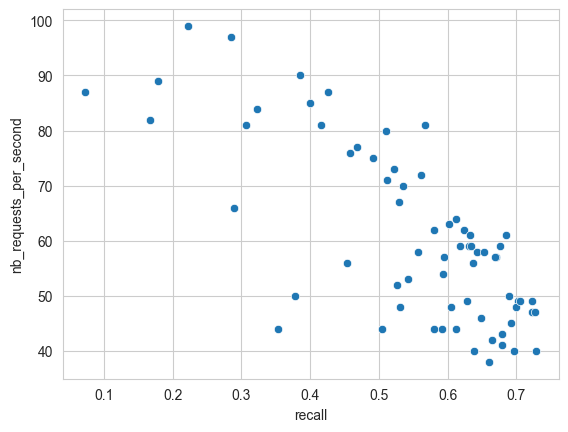

In [29]:

sns_plot = sns.scatterplot(data=bench_kmeans, x="recall", y="nb_requests_per_second",
                           palette=custom_palette)
fig = sns_plot.get_figure()
fig.savefig("../figures/pq_recall_vs_speed.png")